In [4]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test, kstest
from matplotlib.markers import TICKDOWN
import datetime

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
####################################################################################
#    Aggregates SNR (.dat), latency (.dat), and ROI photos (png)
#            scraped from PhotoZ
#    Given ROI files in format slice#_rois.dat 
# 8/23/23 We want to add:
#     Take into account the RELATIVE STIM LOCATION within every barrel. Does velocity depend on distance from stimulating location?
#            New column: distance (um) from stim loc to relevant barrel pair boundary (1:2)
#            New column: distance (um) from stim loc to relevant barrel pair boundary (2:3)
#
#     METHOD
#         To calculate stim location to boundary, take these files produced by MovieMaker2.ipynb:
#             electrode.dat
#             corners_layer.dat
#             corners_barrel.dat
#         Calculate: Distance to lower barrel, distance to higher barrel,
#                    Distance to lower layer, distance to higher layer
#                       (if applicable for each)
####################################################################################

In [5]:
# Load data, not from Drive for Desktop since PhotoZ complains about loading zda from Drive
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
# data_dir = 'C:/Users/jjudg/Downloads/'
cell_type_prefix = 'scnn1a'
csv_prefix = cell_type_prefix + '_all_slices-final.csv'

# load the all-data CSV dir
df = pd.read_csv(data_dir + csv_prefix)
df = pd.DataFrame(df)
df

,Date,Slice/Loc/Rec,Slice Edge,Most Medial Barrel,Medial Dir,Slice Location,Stim Location,Actual Stim Time (ms),Stim Barrel,L4 barrel 1 Latency,...,abs(delta 1),abs(delta 2),Distance to Barrel 1,Distance to Barrel 2,Distance to Layer n1,Distance to Layer n2,Distance to Barrel A,Distance to Barrel B,Distance to Layer nA,Distance to Layer nB
0,2/8/2023,02_01_02,NaN,NaN,NaN,NaN,L4,48.4226,NaN,47.7369,...,NaN,NaN,NaN,NaN,NaN,NaN,215.228351,174.000000,180.093736,191.535134
1,2/10/2023,04_01_07,NaN,NaN,NaN,NaN,L4,48.4429,NaN,52.7236,...,2.7731,NaN,NaN,NaN,NaN,NaN,151.086327,213.337695,149.891961,202.354632
2,2/14/2023,02_01_01,NaN,NaN,NaN,NaN,L4,48.4645,NaN,47.5447,...,NaN,NaN,NaN,NaN,NaN,NaN,198.974687,232.730513,132.022414,229.523778
3,2/14/2023,03_01_03,NaN,NaN,NaN,NaN,L4,48.4195,NaN,51.1559,...,NaN,0.9262,NaN,NaN,NaN,NaN,228.000000,162.000000,159.011987,199.155462
4,2/28/2023,02_01_01,NaN,NaN,NaN,NaN,L5,48.4151,NaN,50.3009,...,NaN,1.4949,NaN,NaN,NaN,NaN,44.346286,328.107622,171.794234,154.795349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,10/19/2023,05_06_02,down/right,1.0,down/left,Anterior,L2/3,48.4228,1.0,52.5402,...,1.2641,NaN,NaN,NaN,NaN,NaN,24.997803,181.431965,314.744870,103.797327
170,10/19/2023,06_01_01,down,3.0,right,Posterior,L4,48.5290,2.0,50.6833,...,0.3503,NaN,NaN,NaN,NaN,NaN,118.898651,202.376373,288.667605,69.296479
171,10/19/2023,06_02_02,down,3.0,right,Posterior,L4,48.4103,3.0,50.3022,...,0.7656,1.0368,NaN,NaN,NaN,NaN,151.005549,215.305522,75.027164,306.897033
172,10/19/2023,06_03_01,down,3.0,right,Posterior,L2/3,48.5911,3.0,52.3050,...,0.5673,NaN,NaN,NaN,NaN,NaN,322.923386,22.555042,70.935246,350.093066


In [6]:
# filter out rows marked in column Exclude 
df2 = df[df["Exclude Reason"].isnull()]
data = {}

for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    print("Barrel pairs in", stim_loc)
    # count number of barrel pairs with no signal crossing
    n_barrel_no_cross = len(df2[df2['# no crossings 2/3'] > 0])
    n_barrel_no_cross += len(df2[df2['# no crossings 1/2'] > 0])
    print("\t", n_barrel_no_cross, "no crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with signal crossing
    n_barrel_cross = len(df2[df2['# crossings 2/3'] > 0])
    n_barrel_cross += len(df2[df2['# crossings 1/2'] > 0])
    print("\t", n_barrel_cross, "crossing out of", len(df2) * 2, "in layer", stim_loc)

    # count number of barrel pairs with no signal
    n_barrel_none = len(df2) * 2 - n_barrel_cross - n_barrel_no_cross
    print("\t", n_barrel_none, "no signal out of", len(df2) * 2, "in layer", stim_loc)
    
    data[stim_loc] = {}
    data[stim_loc]['n_barrel_no_cross'] = n_barrel_no_cross
    data[stim_loc]['n_barrel_cross'] = n_barrel_cross
    data[stim_loc]['n_barrel_none'] = n_barrel_none
    data[stim_loc]['total'] = len(df2) * 2 - n_barrel_none
    
# Now rostral vs caudal
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    for slice_loc in ['Anterior', 'Posterior']:
        print("\n", slice_loc)
        df2_sl = df2[df2['Slice Location'] == slice_loc]
        print("Barrel pairs in", stim_loc)
        # count number of barrel pairs with no signal crossing
        n_barrel_no_cross = len(df2_sl[df2_sl['# no crossings 2/3'] > 0])
        n_barrel_no_cross += len(df2_sl[df2_sl['# no crossings 1/2'] > 0])
        print("\t", n_barrel_no_cross, "no crossing out of", len(df2_sl) * 2, "in layer", stim_loc)

        # count number of barrel pairs with signal crossing
        n_barrel_cross = len(df2_sl[df2_sl['# crossings 2/3'] > 0])
        n_barrel_cross += len(df2_sl[df2_sl['# crossings 1/2'] > 0])
        print("\t", n_barrel_cross, "crossing out of", len(df2_sl) * 2, "in layer", stim_loc)

        # count number of barrel pairs with no signal
        n_barrel_none = len(df2_sl) * 2 - n_barrel_cross - n_barrel_no_cross
        print("\t", n_barrel_none, "no signal out of", len(df2_sl) * 2, "in layer", stim_loc)

        data[stim_loc][slice_loc] = {}
        data[stim_loc][slice_loc]['n_barrel_no_cross'] = n_barrel_no_cross
        data[stim_loc][slice_loc]['n_barrel_cross'] = n_barrel_cross
        data[stim_loc][slice_loc]['n_barrel_none'] = n_barrel_none
        data[stim_loc][slice_loc]['total'] = len(df2) * 2 - n_barrel_none

Barrel pairs in L2/3
	 19 no crossing out of 120 in layer L2/3
	 48 crossing out of 120 in layer L2/3
	 53 no signal out of 120 in layer L2/3
Barrel pairs in L4
	 69 no crossing out of 196 in layer L4
	 35 crossing out of 196 in layer L4
	 92 no signal out of 196 in layer L4
Barrel pairs in L5
	 10 no crossing out of 28 in layer L5
	 7 crossing out of 28 in layer L5
	 11 no signal out of 28 in layer L5

 Anterior
Barrel pairs in L2/3
	 13 no crossing out of 58 in layer L2/3
	 18 crossing out of 58 in layer L2/3
	 27 no signal out of 58 in layer L2/3

 Posterior
Barrel pairs in L2/3
	 4 no crossing out of 42 in layer L2/3
	 15 crossing out of 42 in layer L2/3
	 23 no signal out of 42 in layer L2/3

 Anterior
Barrel pairs in L4
	 26 no crossing out of 84 in layer L4
	 12 crossing out of 84 in layer L4
	 46 no signal out of 84 in layer L4

 Posterior
Barrel pairs in L4
	 29 no crossing out of 82 in layer L4
	 13 crossing out of 82 in layer L4
	 40 no signal out of 82 in layer L4

 Anterio

{'# no crossing': [6.505819318717424, 7.987138329728918, 18.601633295108112], '# crossing': [10.340601836232102, 5.6885382529804, 15.563243006262297]}
{'# no crossing': [28.35820895522388, 66.34615384615384, 58.8235294117647], '# crossing': [71.64179104477611, 33.65384615384615, 41.17647058823529]}
Binomial test for layer L2/3 : 0.00026080637840575794
Binomial test for layer L4 : 0.00026714209499012487
Binomial test for layer L5 : 0.0717315673828125


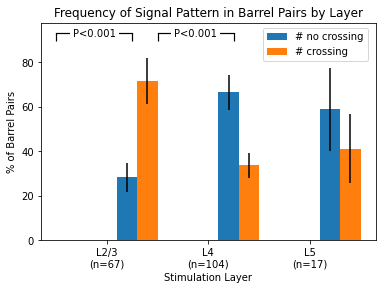

In [7]:
def significance_bar(start,end,height,displaystring,linewidth = 1.2,markersize = 8,boxpad  =0.3,fontsize = 15,color = 'k'):
    # draw a line with downticks at the ends
    plt.plot([start,end],[height]*2,'-',color = color,lw=linewidth,marker = TICKDOWN,markeredgewidth=linewidth,markersize = markersize)
    # draw the text with a bounding box covering up the line
    plt.text(0.5*(start+end),height,displaystring,ha = 'center',va='center',bbox=dict(facecolor='1.', edgecolor='none',boxstyle='Square,pad='+str(boxpad)),size = fontsize)

n_L23 = data['L2/3']['total']
n_L4 = data['L4']['total']
n_L5 = data['L5']['total']

plt.clf()
i = 0
tick_labels = []
colors = {"# no crossing": 'tab:blue', "# crossing": 'tab:orange'}
# in format # no crossing, # crossing, # no signal; l2/3, L4, L5

length_of_previous_sl = i

all_layers = []
totals = []
if n_L23 > 0:
    all_layers.append('L2/3')
    totals.append(n_L23)
if n_L4 > 0:
    all_layers.append('L4')
    totals.append(n_L4)
if n_L5 > 0:
    all_layers.append('L5')
    totals.append(n_L5)


# in columns L23, L4, L5
crossing_data = {
    "# no crossing": [data[x]['n_barrel_no_cross'] for x in all_layers],
    '# crossing': [data[x]['n_barrel_cross'] for x in all_layers],
    #'# no signal': [data[x]['n_barrel_none'] for x in ['L2/3', 'L4', 'L5']],
    #"L2/3": [3, 17, 30],
    #"L4": [38, 20, 30],
    #"L5": [8, 13, 1]
}
errbars = {}
for k in crossing_data:
    errbars[k] = [np.sqrt(x) for x in crossing_data[k]]
    for j in range(len(totals)):
        crossing_data[k][j] /= totals[j] / 100
        errbars[k][j] /= totals[j] / 100

labels = [x for x in crossing_data.keys()]
tick_labels += [all_layers[j] + "\n(n="+str(totals[j]) + ")"
                            for j in range(len(all_layers))]

print(errbars)
print(crossing_data)

# This is a binomial experiment of n independent trials.
# We use the Binomial case of goodness of fit test to a 
# chi-squared distribution
Zs = []
for i in range(3):
    layer = ['L2/3', 'L4', 'L5'][i]
    n = [n_L23, n_L4, n_L5][i]
    no_cr = crossing_data['# no crossing'][i]
    cr = crossing_data['# crossing'][i]
    k = n * cr / 100 # number of crosses
    
    null_hyp_p = 0.5
    
    Z = binom_test(k, n, null_hyp_p, alternative='greater')
    if Z > 0.5:
        Z = 1 - Z
    print("Binomial test for layer", layer, ":", Z)
    Zs.append(Z)
    
##########################
for nm in crossing_data:
    x = np.arange(len(all_layers))
    # else:
    plt.bar(x + (i-1) * 0.2, 
        crossing_data[nm],
        0.2,
        label=(nm if length_of_previous_sl == 0 else None),
        color=colors[nm])
    plt.errorbar(x + (i-1) * 0.2, 
                crossing_data[nm],
                yerr=errbars[nm],
                fmt='none',
                color='black')
    i += 1

for i in range(3):
    if Zs[i] < 0.001:
        significance_bar(i-.5, i+0.25, 93, "P<0.001", fontsize=10)
    
plt.title("Frequency of Signal Pattern in Barrel Pairs by Layer")
plt.xlabel("Stimulation Layer")
plt.ylabel("% of Barrel Pairs")
#plt.xticks(rotation='vertical')
plt.xticks(np.arange(len(tick_labels)), tick_labels)
plt.legend(bbox_to_anchor=(0.82, 1.0), loc='upper center')
plt.savefig(data_dir + "results_count_oct2023.png")
plt.show()

In [8]:
# use Slice Edge and Medial Dir metadata
# to tell which barrel is more medial
# Mark this as Medial Crossing or Medial no crossing or lateral etc

In [9]:
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    dfd1 = df2['abs(delta 1)'].dropna()
    dfd2 = df2['abs(delta 2)'].dropna()

    print("Latency between barrel pairs in", stim_loc)
    dfds = np.concatenate([dfd1, dfd2])
    print("\t", 
          str(np.mean(dfds))[:5], 
          "+/-", 
          str(np.std(dfds))[:5], 
          "(n =", 
          str(len(dfds)) + ")")
    print("\t", dfds)

Latency between barrel pairs in L2/3
	 0.690 +/- 0.619 (n = 26)
	 [1.3583 1.4885 0.2138 0.0093 0.1229 0.0447 1.1051 0.3143 0.1379 1.2641
 0.5673 2.4054 1.6877 0.7967 0.2299 0.7214 0.2692 1.2911 0.5468 0.0567
 0.1857 0.145  0.1196 1.252  1.0902 0.5346]
Latency between barrel pairs in L4
	 1.028 +/- 1.001 (n = 25)
	 [2.7731 0.0717 1.222  0.1611 1.3073 1.6698 0.4578 0.695  1.9031 0.3503
 0.7656 0.9262 0.957  1.3192 0.0676 2.1705 0.1656 0.7253 0.853  0.543
 0.3128 4.6423 0.1724 0.4323 1.0368]
Latency between barrel pairs in L5
	 0.764 +/- 0.546 (n = 6)
	 [0.1239 0.5704 1.4949 0.5802 1.5165 0.3024]


Latency between anterior (rostral) barrel pairs in L2/3
	 0.373 +/- 0.430 (n = 10)
	 [0.0093 0.1229 0.0447 0.3143 0.1379 1.2641 0.5468 0.0567 0.145  1.0902]
Latency between posterior (caudal) barrel pairs in L2/3
	 0.932 +/- 0.701 (n = 8)
	 [1.1051 0.5673 2.4054 1.2911 0.1857 0.1196 1.252  0.5346]
Latency between anterior (rostral) barrel pairs in L4
	 1.258 +/- 1.284 (n = 9)
	 [1.3073 0.4578 0.695  1.9031 0.7253 0.853  0.3128 4.6423 0.4323]
Latency between posterior (caudal) barrel pairs in L4
	 0.781 +/- 0.680 (n = 9)
	 [0.1611 1.6698 0.3503 0.7656 2.1705 0.1656 0.543  0.1724 1.0368]
KS test for ant layer L2/3 and ant layer L4 is significant with p-value  0.03026694667561547
KS test for ant layer L4 and ant layer L2/3 is significant with p-value  0.03026694667561547
KS test for ant layer L2/3 and post layer L4 is significant with p-value  0.03026694667561547
KS test for post layer L4 and ant layer L2/3 is significant with p-value  0.03026694667561547


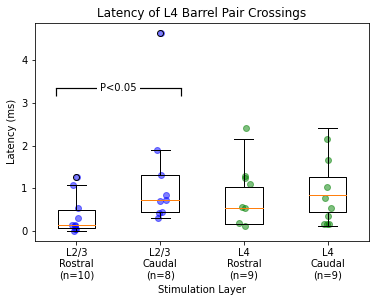

In [10]:
dists = {"ant": {'L2/3': [],
                 'L4': [],
                 'L5': []},
         "post": {'L2/3': [],
                 'L4': [],
                 'L5': []}
         }
plt.clf()
i = 1
xtick_labels = []
df_datasets_ant = []
df_datasets_post = []
for stim_loc in ['L2/3', 'L4', 'L5']:
    df2 = df[df['Stim Location'].str.contains(stim_loc)]
    
    df2_ant = df2[df2['Slice Location'] == "Anterior"]
    dfd1_ant = df2_ant['abs(delta 1)'].dropna()
    dfd2_ant = df2_ant['abs(delta 2)'].dropna()
    
    df2_post = df2[df2['Slice Location'] == "Posterior"]
    dfd1_post = df2_post['abs(delta 1)'].dropna()
    dfd2_post = df2_post['abs(delta 2)'].dropna()
    
    dfds_ant = np.concatenate([dfd1_ant, dfd2_ant])
    dfds_post = np.concatenate([dfd1_post, dfd2_post])
    
    if len(dfds_ant) > 3:
        dists['ant'][stim_loc] = dfds_ant
        print("Latency between anterior (rostral) barrel pairs in", stim_loc)
        print("\t", 
              str(np.mean(dfds_ant))[:5], 
              "+/-", 
              str(np.std(dfds_ant))[:5], 
              "(n =", 
              str(len(dfds_ant)) + ")")
        print("\t", dfds_ant)
    if len(dfds_post) > 3:
        dists['post'][stim_loc] = dfds_post
        print("Latency between posterior (caudal) barrel pairs in", stim_loc)
        print("\t", 
              str(np.mean(dfds_post))[:5], 
              "+/-", 
              str(np.std(dfds_post))[:5], 
              "(n =", 
              str(len(dfds_post)) + ")")
        print("\t", dfds_post)
    if len(dfds_post) < 3 and len(dfds_ant) < 3:
        continue
    
    jittered_xs_1 = np.random.normal(i, 0.04, dfds_ant.shape[0])
    jittered_xs_2 = np.random.normal(i+2, 0.04, dfds_post.shape[0])
    plt.scatter(jittered_xs_1, dfds_ant, alpha=0.5, color='blue')
    plt.scatter(jittered_xs_2, dfds_post, alpha=0.5, color='green')

    xtick_labels.append(stim_loc + "\nRostral\n(n=" + str(len(dfds_ant)) +")")
    xtick_labels.append(stim_loc + "\nCaudal\n(n=" + str(len(dfds_post)) +")")
    df_datasets_ant.append(dfds_ant)
    df_datasets_post.append(dfds_post)
    i += 1

# calculate significance
for sl1 in ['ant', 'post']:
    for sl2 in ['ant', 'post']:
        for la1 in ['L2/3', 'L4', 'L5']:
            for la2 in ['L2/3', 'L4', 'L5']:
                if sl1 == sl2 and la1 == la2:
                    continue
                elif len(dists[sl1][la1]) < 3 or len(dists[sl2][la2]) < 3:
                    continue
                else:
                    p_val = kstest(dists[sl1][la1], dists[sl2][la2]).pvalue
                    if p_val < 0.05:
                        print('KS test for ' + sl1 + " layer " + la1 + " and", 
                              sl2 + " layer " + la2,
                             "is significant with p-value ", p_val)

# significance: L2/3 Rostral and L4 Rostral, and 
#               L2/3 Rostral and L4 Caudal
significance_bar(0.75, 2.25, 3.35, "P<0.05", fontsize=10)
# significance_bar(0.75, 4.25, 3.75, "P<0.05", fontsize=10) -- not signficant when correcting for multiple tests

df_datasets_post.reverse()
plt.boxplot(df_datasets_ant + df_datasets_post)
plt.xticks(range(1, len(xtick_labels)+1), xtick_labels)
plt.title("Latency of L4 Barrel Pair Crossings")
plt.xlabel("Stimulation Layer")
plt.ylabel("Latency (ms)")
plt.savefig(data_dir + cell_type_prefix + "_results_latency_prelim_" + str(datetime.date.today()) +".png", bbox_inches="tight")
plt.show()
